## Importando dependências

In [1]:
import sys
import numpy as np
import pandas as pd
from pandas import DataFrame
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import Loss
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, classification_report
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler, SMOTE

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Importando dataset e splitando em teste e treino

In [2]:
def normalize_dataset_labels(dataset):
    y = dataset.iloc[:, -1].values
    y = np.array(y, dtype=np.float64)
    unique_labels = sorted(list(set(y)))
    for i in range(len(y)):
        y[i] = unique_labels.index(y[i])

    dataset.iloc[:, -1] = y
    
def binarize_dataset_labels(dataset):
    y = dataset.iloc[:, -1].values
    binarizer = Binarizer()
    y = binarizer.fit_transform([y])[0]
    dataset.iloc[:, -1] = y
    

HEADER = ["timestamp",'srcip', 'srcport', 'dstip', 'dstport', 'proto', 'total_fpackets', 'total_fvolume',
          'total_bpackets', 'total_bvolume', 'min_fpktl', 'mean_fpktl', 'max_fpktl', 'std_fpktl', 'min_bpktl',
          'mean_bpktl', 'max_bpktl', 'std_bpktl', 'min_fiat', 'mean_fiat', 'max_fiat', 'std_fiat', 'min_biat',
          'mean_biat', 'max_biat', 'std_biat', 'duration', 'min_active', 'mean_active', 'max_active', 'std_active',
          'min_idle', 'mean_idle', 'max_idle', 'std_idle', 'sflow_fpackets', 'sflow_fbytes', 'sflow_bpackets',
          'sflow_bbytes', 'fpsh_cnt', 'bpsh_cnt', 'furg_cnt', 'burg_cnt', 'total_fhlen', 'total_bhlen', "dscp", 'class']
initial_dataset_02_24 = pd.read_csv('dataset-oi-2017-02-24-summarized.csv', names=HEADER, header=1)
initial_dataset_02_25 = pd.read_csv('dataset-oi-2017-02-25-summarized.csv', names=HEADER, header=1)
initial_dataset_02_26 = pd.read_csv('dataset-oi-2017-02-26-summarized.csv', names=HEADER, header=1)
# initial_dataset_02_27 = pd.read_csv('dataset-oi-2017-02-27-summarized.csv', names=HEADER, header=1)
# initial_dataset_02_28 = pd.read_csv('dataset-oi-2017-02-28-summarized.csv', names=HEADER, header=1)

initial_dataset_02_24 = initial_dataset_02_24.replace([np.inf, -np.inf], np.nan).dropna()
initial_dataset_02_25 = initial_dataset_02_25.replace([np.inf, -np.inf], np.nan).dropna()
initial_dataset_02_26 = initial_dataset_02_26.replace([np.inf, -np.inf], np.nan).dropna()
# initial_dataset_02_27 = initial_dataset_02_27.replace([np.inf, -np.inf], np.nan).dropna()
# initial_dataset_02_28 = initial_dataset_02_28.replace([np.inf, -np.inf], np.nan).dropna()

initial_dataset = initial_dataset_02_24.append(initial_dataset_02_25, ignore_index=True)
initial_dataset = initial_dataset.append(initial_dataset_02_26, ignore_index=True)
# initial_dataset = initial_dataset.append(initial_dataset_02_27, ignore_index=True)
# initial_dataset = initial_dataset.append(initial_dataset_02_28, ignore_index=True)

binarize_dataset_labels(initial_dataset)

## Criando modelo da rede neural

In [3]:
class Net:
    def build(self, shape = (41,), classes = 10):
        model = Sequential()
        model.add(Dense(200, input_shape=shape))
        model.add(Activation("relu"))
        model.add(Dense(200))
        model.add(Activation("relu"))
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        
        self.built = model
        return model
    
    def compile(self):
        self.built.compile(loss = 'sparse_categorical_crossentropy', 
                           optimizer = 'adam',
                           metrics = ['accuracy'])

## Criando modelo do servidor

In [4]:
class Server:
    def __init__(self, num_clients, num_labels, input_shape, model = Net()):
        self.global_model = model
        self.num_clients = num_clients
        
        self.global_model.build(classes =num_labels, shape = input_shape)
        self.global_model.compile()
            
    def agregate_models(self, clients_train_data):
        _, clients_data_size = zip(*clients_train_data)
        global_data_size = sum(list(clients_data_size))
        scaled_models_weights = list()
        
        for local_weights, local_data_size in clients_train_data:
            client_mean = local_data_size / global_data_size
            scaled_local_weights = list()
            
            for weight in local_weights:
                scaled_weight = weight * client_mean
                scaled_local_weights.append(scaled_weight)
                
            scaled_models_weights.append(scaled_local_weights)
           
        average_model_weights = list()
        for model_weights in zip(*scaled_models_weights):
            layer_mean = tf.math.reduce_sum(model_weights, axis=0)
            average_model_weights.append(layer_mean)
            
        self.global_model.built.set_weights(average_model_weights)
        
    def send_global_model_weights(self, clients):
        global_model_weights = self.global_model.built.get_weights()
        for client in clients:
            client.set_model_weights(global_model_weights)

## Criando modelo do cliente

In [12]:
class Client:
    def __init__(self, client_id = 123, dataset = list(), model = Net(), num_labels = 10):
        self.client_id = client_id
        self.local_dataset = pd.DataFrame(dataset)
        self.local_model = model
        self.num_labels = num_labels
        self.metrics_history = list()
        
    def apply_oversample(self, X, y):
        labels_counts = self.local_dataset['class'].value_counts()
        target_label = labels_counts.keys()[1]
        max_samples = int(labels_counts.values[0] * 0.6)
        current_samples = labels_counts.values[1]
        
        if current_samples >= max_samples:
            return X, y
        
        smote_oversample = SMOTE(sampling_strategy={target_label: max_samples}, random_state=0)
        return smote_oversample.fit_resample(X, y)
        
        
#     def apply_oversample(self, X, y):
#         value_counts = self.local_dataset.iloc[:, -1].value_counts()
#         smote_classes, random_classes, k = ({}, {}, sys.maxsize)
#         max_count = int(max(value_counts.values) * 0.7)

#         for key, value in value_counts.items():
#             if value > 5:
#                 if value_counts[key] < max_count:
#                     smote_classes[key] = max_count
#                 if k > value:
#                     k = value - 1
#             else:
#                 random_classes[key] = max_count

#         smote_oversample = SMOTE(sampling_strategy = smote_classes, k_neighbors = k)
#         random_oversample = RandomOverSampler(sampling_strategy = random_classes)
#         X, y = smote_oversample.fit_resample(X, y)
#         return random_oversample.fit_resample(X, y)
        
    def preprocess(self):
        X = self.local_dataset.iloc[:, 5:-1].values
        y = self.local_dataset.iloc[:, -1].values

        X, y = self.apply_oversample(X, y)
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
       
        
    def train_model(self):
        self.local_model.compile()
        self.local_model.built.fit(self.X_train, 
                                   self.y_train, 
                                   batch_size = 128,
                                   epochs=10, 
                                   verbose=0)
        print()
        
    def test_model(self):
        print(f"[INFO] Local test of client {self.client_id}")
        y_pred = self.local_model.built.predict(self.X_test).argmax(axis=1)
        y_score = self.local_model.built.predict(self.X_test)[:,1]
        
        prec = precision_score(self.y_test, y_pred, average = 'micro')
        rec = recall_score(self.y_test, y_pred, average = 'micro')
        auc = roc_auc_score(self.y_test, y_score)
        self.report = classification_report(self.y_test, y_pred, zero_division=0)
        self.fpr, self.tpr, _ = roc_curve(self.y_test, y_score)
        
        loss, acc = self.local_model.built.evaluate(self.X_test, self.y_test)
        
        self.metrics_history.append((loss, acc, prec, rec, auc))
        
        cm = confusion_matrix(self.y_test, y_pred)
        print(cm) 
        print(self.report)
        
    def plot_result(self, rounds):
        loss_history, acc_history, prec_history, rec_history, auc_history = zip(*self.metrics_history)
        epochs = range(1, rounds + 1)
        plt.plot(epochs, loss_history, 'g', label='Loss')
        plt.plot(epochs, acc_history, 'b', label='Accuracy')
        plt.title(f'Loss and Accuracy score history of client {self.client_id}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss and Accuracy score')
        plt.legend()
        plt.show()
        
        plt.plot(epochs, prec_history, 'y', label='Precision')
        plt.plot(epochs, rec_history, 'k', label='Recall')
        plt.plot(epochs, auc_history, 'g', label='AUC')
        plt.title(f'Precision, Recall and AUC score history of client {self.client_id}')
        plt.xlabel('Epochs')
        plt.ylabel('Precision, Recall and AUC score')
        plt.legend()
        plt.show()
        
        plt.plot(self.fpr, self.tpr, marker='.', label='Net classification')
        plt.title(f'ROC Curve of client {self.client_id}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()
        
    def set_model_weights(self, global_model_weights):
        self.local_model.build(classes = self.num_labels, shape = self.input_shape)
        self.local_model.built.set_weights(global_model_weights)

## Splitando dataset para os clientes da rede

In [13]:
import random
def split_dataset_non_iid(clients, num_labels, input_shape):
        unique_ips = initial_dataset['srcip'].value_counts().head(100).keys()
        ips_range = len(unique_ips)
        client_index, id_list = (0,[])
        while client_index < num_clients:
            srcip_id = random.randint(0,ips_range)
            if srcip_id not in id_list:
                id_list.append(srcip_id)
                local_dataset = initial_dataset.loc[initial_dataset['srcip'] == unique_ips[srcip_id]]
                value_counts = local_dataset['class'].value_counts()
                num_classes = len(value_counts)
                if num_classes > 1:
                    print(f"Value counts for client {client_index}\n{value_counts}")
                    clients[client_index].local_dataset = local_dataset
                    clients[client_index].num_labels = num_labels
                    clients[client_index].input_shape = input_shape
                    client_index += 1
            
            

num_clients = 20
train_rounds = 10
X = initial_dataset.iloc[:, 5:-1].values
y = initial_dataset.iloc[:, -1].values
num_labels = len(set(y))
input_shape = X.shape[1:]

server = Server(num_clients, num_labels, input_shape)
clients = [Client(client_id = i) for i in range(num_clients)]

split_dataset_non_iid(clients, num_labels, input_shape)

Value counts for client 0
0.0    47306
1.0       26
Name: class, dtype: int64
Value counts for client 1
0.0    33993
1.0       57
Name: class, dtype: int64
Value counts for client 2
0.0    77015
1.0     4886
Name: class, dtype: int64
Value counts for client 3
0.0    33545
1.0       52
Name: class, dtype: int64
Value counts for client 4
0.0    70730
1.0      111
Name: class, dtype: int64
Value counts for client 5
0.0    32354
1.0      126
Name: class, dtype: int64
Value counts for client 6
0.0    24719
1.0     2745
Name: class, dtype: int64
Value counts for client 7
0.0    53487
1.0    15143
Name: class, dtype: int64
Value counts for client 8
0.0    22622
1.0     7976
Name: class, dtype: int64
Value counts for client 9
0.0    25167
1.0      392
Name: class, dtype: int64
Value counts for client 10
0.0    18570
1.0     9133
Name: class, dtype: int64
Value counts for client 11
0.0    42555
1.0       12
Name: class, dtype: int64
Value counts for client 12
0.0    54947
1.0      297
Name: cla

## Treinando e testando modelos NN locais

In [14]:
for client in clients:
    client.preprocess()

for i in range(train_rounds):
    local_clients_train = list()
    server.send_global_model_weights(clients)

    for client in clients:
        client.train_model()
        
        local_weight = client.local_model.built.get_weights()
        local_dataset_size = len(client.local_dataset)
        local_clients_train.append((local_weight, local_dataset_size))

        client.test_model()
        
    print(f"[INFO] Local train {i} finished!")
    server.agregate_models(local_clients_train)
    
print(f"[INFO] All local trains are finished!")


[INFO] Local test of client 0
474/474 [==============================] - 0s 395us/step - loss: 0.2283 - accuracy: 0.9851
[[9287  143]
 [  83 5625]]
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      9430
         1.0       0.98      0.99      0.98      5708

    accuracy                           0.99     15138
   macro avg       0.98      0.99      0.98     15138
weighted avg       0.99      0.99      0.99     15138


[INFO] Local test of client 1
340/340 [==============================] - 0s 384us/step - loss: 0.0043 - accuracy: 0.9994
[[6761    6]
 [   0 4111]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6767
         1.0       1.00      1.00      1.00      4111

    accuracy                           1.00     10878
   macro avg       1.00      1.00      1.00     10878
weighted avg       1.00      1.00      1.00     10878


[INFO] Local test of client 2
771/771 [========

## Plotando resultados dos treinos locais

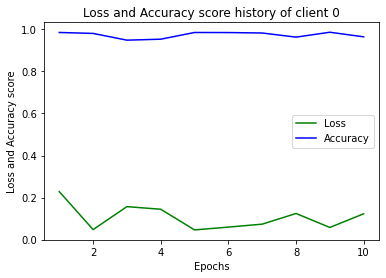

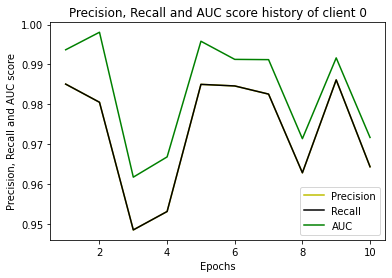

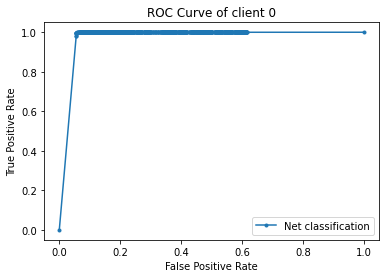

Class report of client 0
              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97      9430
         1.0       0.91      1.00      0.95      5708

    accuracy                           0.96     15138
   macro avg       0.96      0.97      0.96     15138
weighted avg       0.97      0.96      0.96     15138



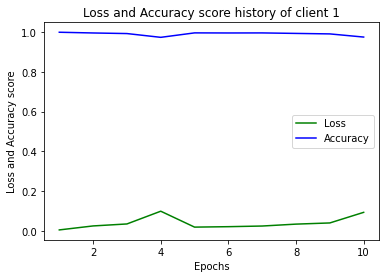

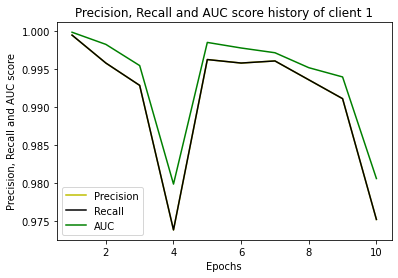

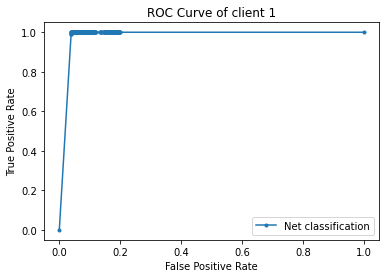

Class report of client 1
              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98      6767
         1.0       0.94      1.00      0.97      4111

    accuracy                           0.98     10878
   macro avg       0.97      0.98      0.97     10878
weighted avg       0.98      0.98      0.98     10878



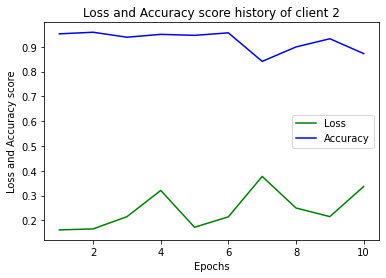

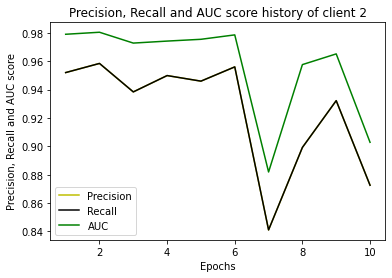

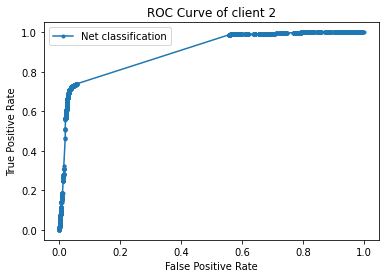

Class report of client 2
              precision    recall  f1-score   support

         0.0       0.86      0.96      0.90     15447
         1.0       0.91      0.73      0.81      9198

    accuracy                           0.87     24645
   macro avg       0.88      0.84      0.86     24645
weighted avg       0.88      0.87      0.87     24645



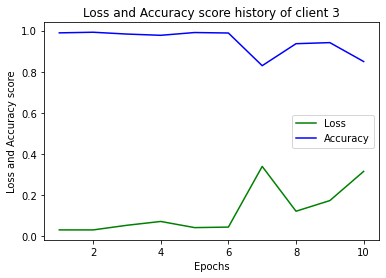

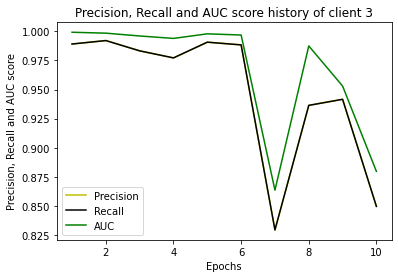

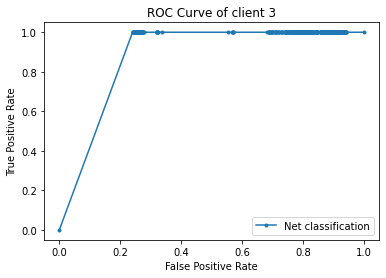

Class report of client 3
              precision    recall  f1-score   support

         0.0       1.00      0.76      0.86      6704
         1.0       0.71      1.00      0.83      4031

    accuracy                           0.85     10735
   macro avg       0.86      0.88      0.85     10735
weighted avg       0.89      0.85      0.85     10735



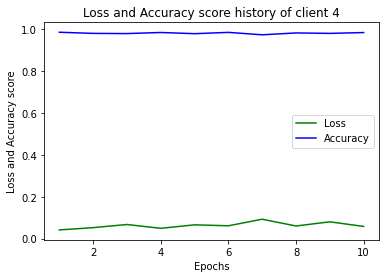

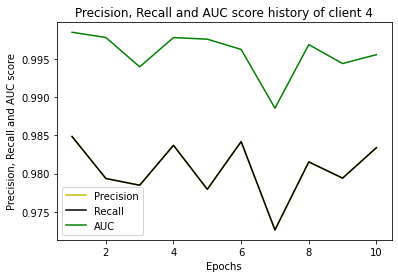

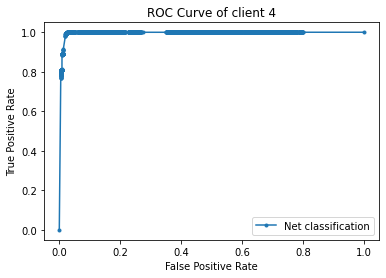

Class report of client 4
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     14113
         1.0       0.96      0.99      0.98      8521

    accuracy                           0.98     22634
   macro avg       0.98      0.99      0.98     22634
weighted avg       0.98      0.98      0.98     22634



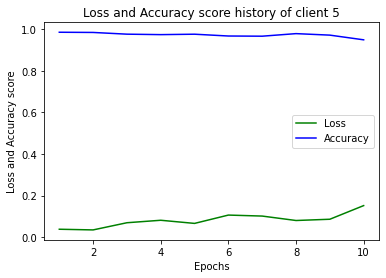

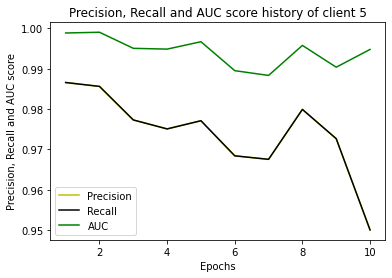

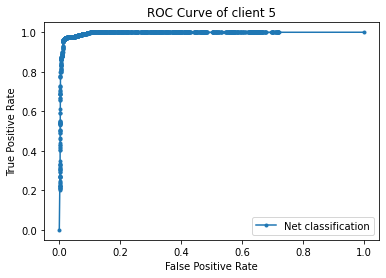

Class report of client 5
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      6414
         1.0       0.99      0.88      0.93      3940

    accuracy                           0.95     10354
   macro avg       0.96      0.94      0.95     10354
weighted avg       0.95      0.95      0.95     10354



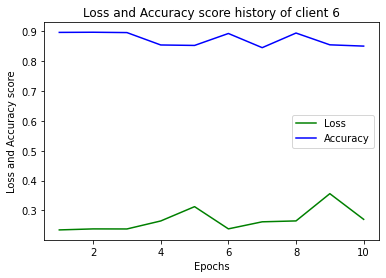

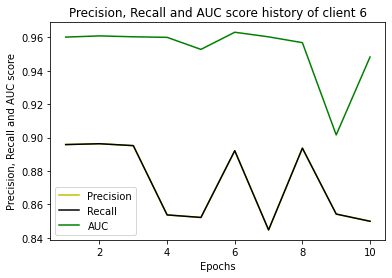

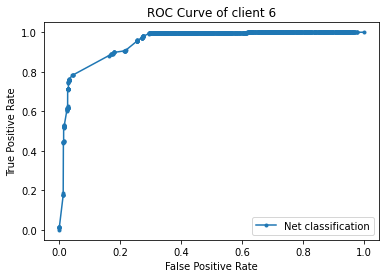

Class report of client 6
              precision    recall  f1-score   support

         0.0       0.93      0.82      0.87      4904
         1.0       0.75      0.90      0.82      3006

    accuracy                           0.85      7910
   macro avg       0.84      0.86      0.85      7910
weighted avg       0.86      0.85      0.85      7910



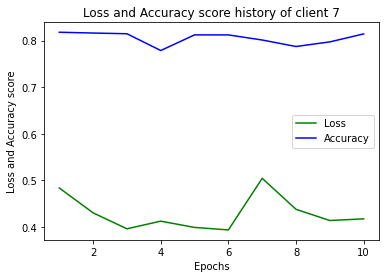

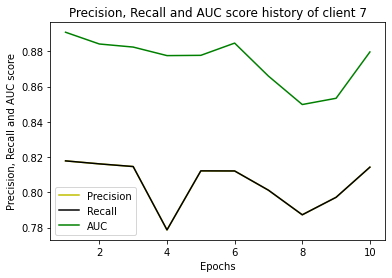

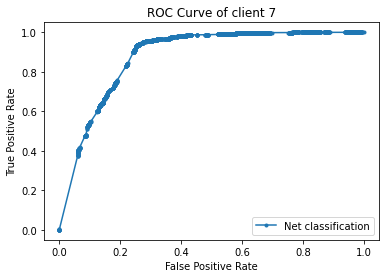

Class report of client 7
              precision    recall  f1-score   support

         0.0       0.95      0.75      0.83     10763
         1.0       0.68      0.93      0.79      6353

    accuracy                           0.81     17116
   macro avg       0.82      0.84      0.81     17116
weighted avg       0.85      0.81      0.82     17116



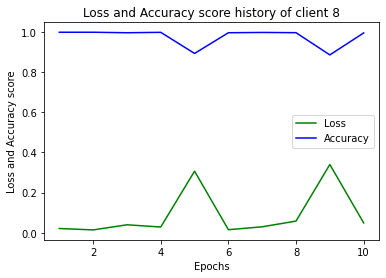

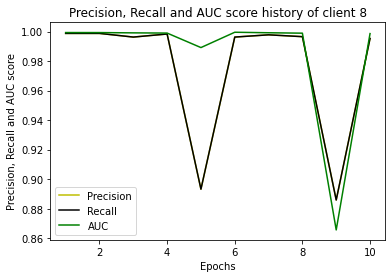

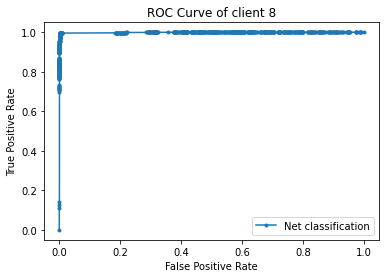

Class report of client 8
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      4471
         1.0       0.99      0.99      0.99      2768

    accuracy                           1.00      7239
   macro avg       0.99      1.00      1.00      7239
weighted avg       1.00      1.00      1.00      7239



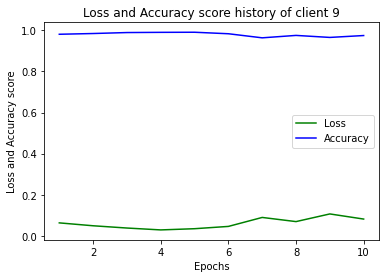

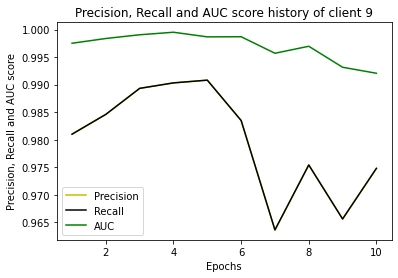

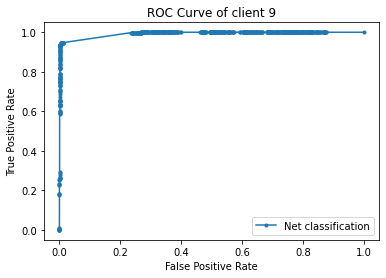

Class report of client 9
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      5078
         1.0       0.99      0.94      0.96      2976

    accuracy                           0.97      8054
   macro avg       0.98      0.97      0.97      8054
weighted avg       0.98      0.97      0.97      8054



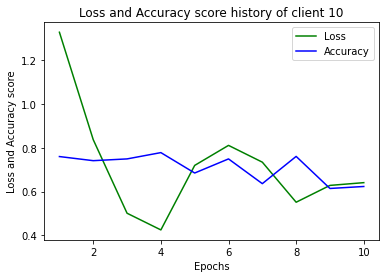

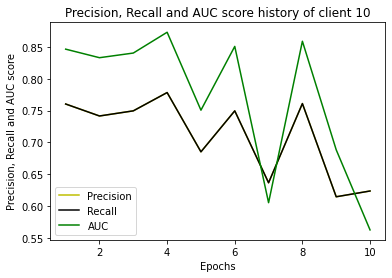

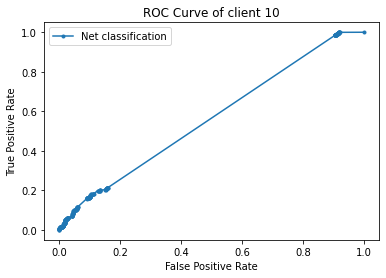

Class report of client 10
              precision    recall  f1-score   support

         0.0       0.63      0.95      0.76      3682
         1.0       0.53      0.09      0.15      2261

    accuracy                           0.62      5943
   macro avg       0.58      0.52      0.45      5943
weighted avg       0.59      0.62      0.53      5943



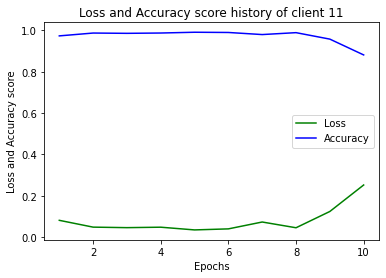

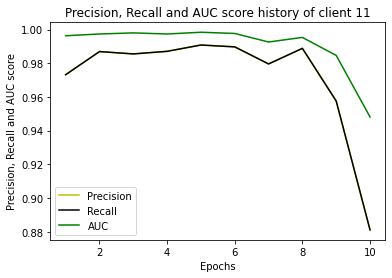

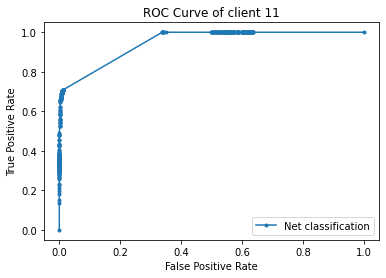

Class report of client 11
              precision    recall  f1-score   support

         0.0       0.84      0.99      0.91      8423
         1.0       0.98      0.70      0.82      5195

    accuracy                           0.88     13618
   macro avg       0.91      0.85      0.86     13618
weighted avg       0.90      0.88      0.88     13618



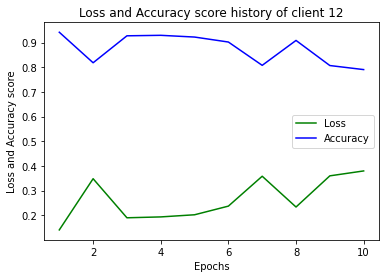

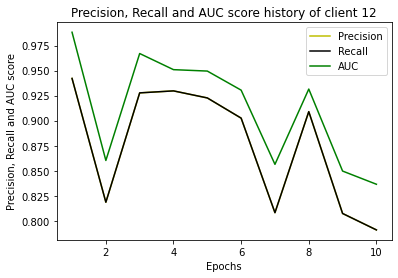

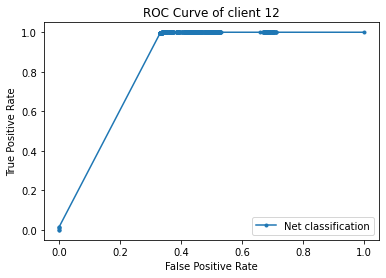

Class report of client 12
              precision    recall  f1-score   support

         0.0       1.00      0.67      0.80     11010
         1.0       0.64      1.00      0.78      6573

    accuracy                           0.79     17583
   macro avg       0.82      0.83      0.79     17583
weighted avg       0.86      0.79      0.79     17583



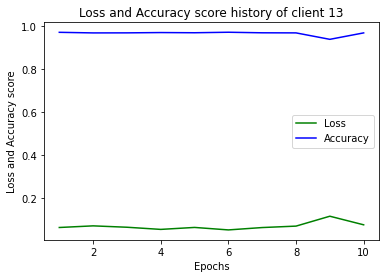

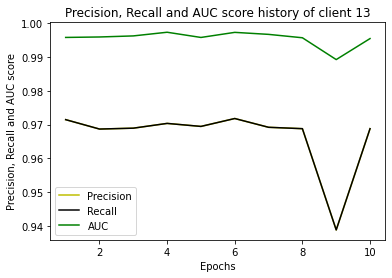

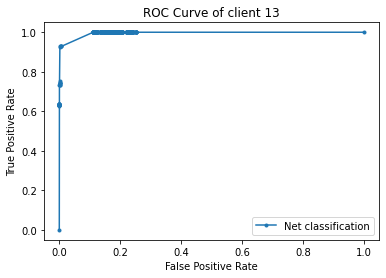

Class report of client 13
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98     16754
         1.0       0.99      0.93      0.96     10211

    accuracy                           0.97     26965
   macro avg       0.97      0.96      0.97     26965
weighted avg       0.97      0.97      0.97     26965



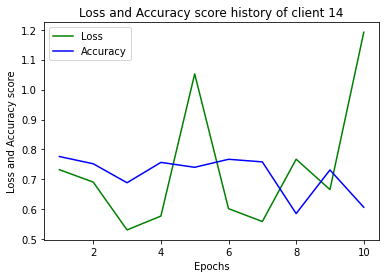

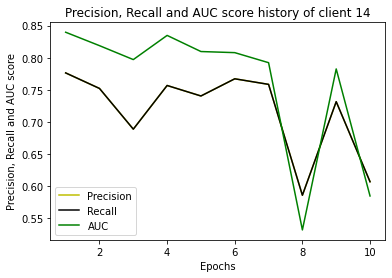

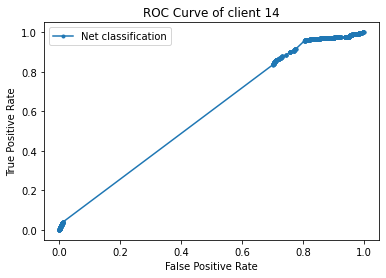

Class report of client 14
              precision    recall  f1-score   support

         0.0       0.61      0.29      0.39      9637
         1.0       0.61      0.86      0.71     12268

    accuracy                           0.61     21905
   macro avg       0.61      0.57      0.55     21905
weighted avg       0.61      0.61      0.57     21905



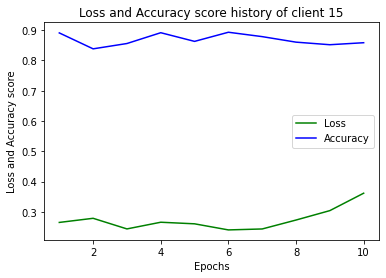

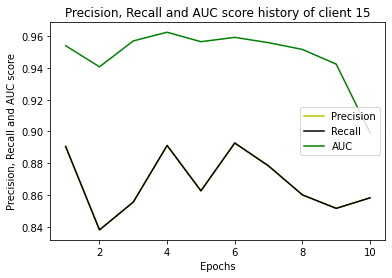

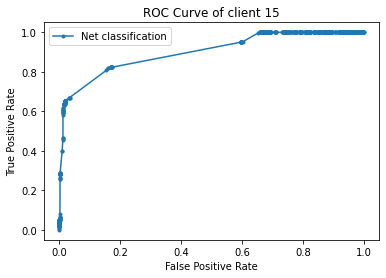

Class report of client 15
              precision    recall  f1-score   support

         0.0       0.83      0.98      0.90      5691
         1.0       0.95      0.65      0.77      3370

    accuracy                           0.86      9061
   macro avg       0.89      0.82      0.83      9061
weighted avg       0.87      0.86      0.85      9061



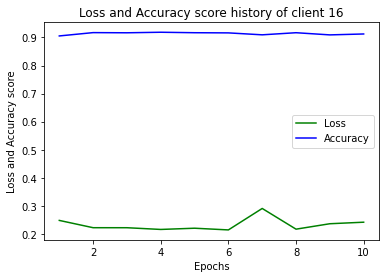

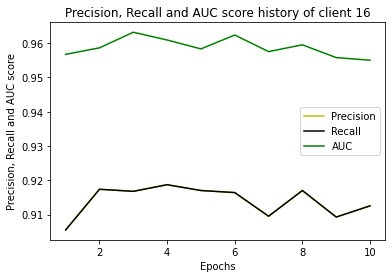

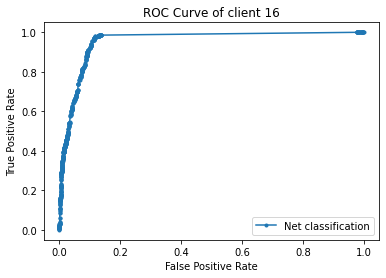

Class report of client 16
              precision    recall  f1-score   support

         0.0       0.99      0.87      0.93      5175
         1.0       0.82      0.98      0.89      3094

    accuracy                           0.91      8269
   macro avg       0.90      0.93      0.91      8269
weighted avg       0.92      0.91      0.91      8269



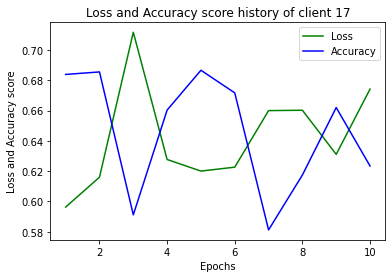

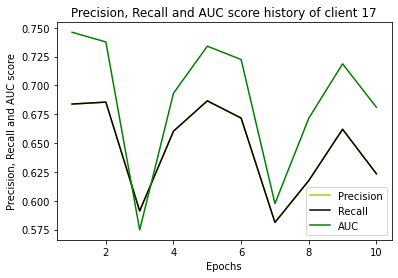

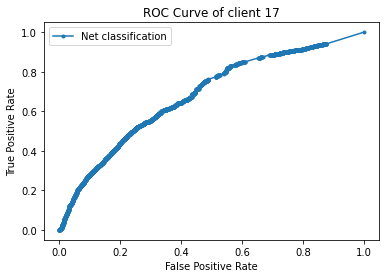

Class report of client 17
              precision    recall  f1-score   support

         0.0       0.65      0.62      0.64      3852
         1.0       0.59      0.62      0.61      3373

    accuracy                           0.62      7225
   macro avg       0.62      0.62      0.62      7225
weighted avg       0.63      0.62      0.62      7225



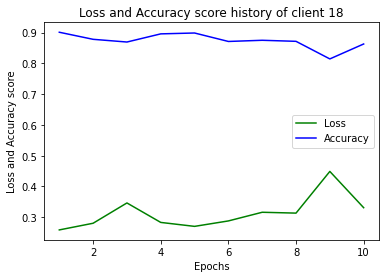

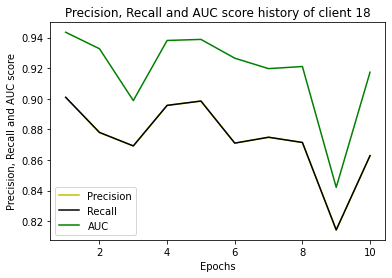

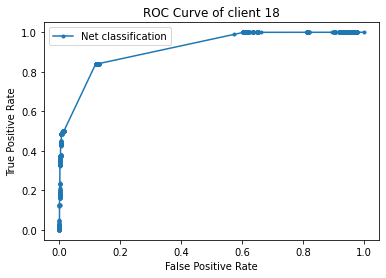

Class report of client 18
              precision    recall  f1-score   support

         0.0       0.90      0.88      0.89     17661
         1.0       0.81      0.84      0.82     10763

    accuracy                           0.86     28424
   macro avg       0.85      0.86      0.86     28424
weighted avg       0.86      0.86      0.86     28424



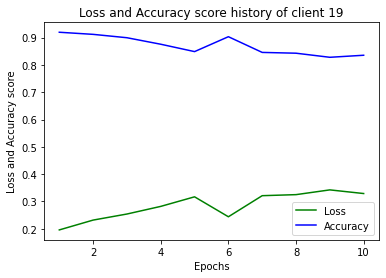

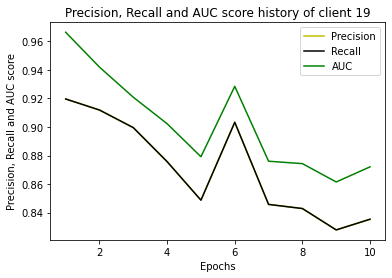

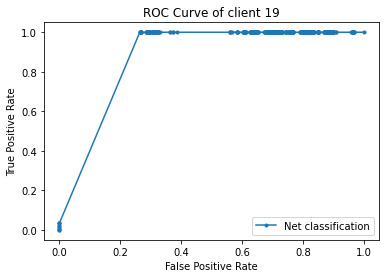

Class report of client 19
              precision    recall  f1-score   support

         0.0       1.00      0.74      0.85      7303
         1.0       0.70      1.00      0.82      4446

    accuracy                           0.84     11749
   macro avg       0.85      0.87      0.83     11749
weighted avg       0.89      0.84      0.84     11749



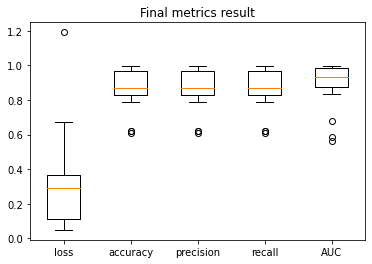

In [15]:
final_metrics = [[],[],[],[],[]]
for client in clients:
    client.plot_result(train_rounds)
    print(f"Class report of client {client.client_id}\n{client.report}")
    for i in range(5):
        final_metrics[i].append(client.metrics_history[-1][i])

plt.boxplot(final_metrics)
plt.title('Final metrics result')
plt.xticks([1,2,3,4,5], ['loss', 'accuracy', 'precision', 'recall', 'AUC'])
plt.show()